In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from transform import LinearTransform
from transform import MultiLayerPerceptron as MLP
from aevb import AutoEncodingVariationalBayes as vae
from aevb import FLDSVB
from dynamics import FLDS, KalmanFilter
from model import ReparameterizedDistribution
from distribution import MultiplicativeNormal
from vis.dynamic import plot_paths

from norm_flow import TimeAutoRegressivePlanarFlow
from norm_flow_model import NormalizingFlowModel
from distribution import StateSpaceNormalDiag

# Generating Synthetic Data Set

Generating Synthetic Data Set
We consider the Kalman Filter model with diagonal covariances. Latent variables are denoted by $z_1, \ldots, z_T \in \mathbb{R}^{d}$ and observations are denoted by $x_1, \ldots, x_T \in \mathbb{R}^{m}$.

- $z_1 \sim \mathcal{N}(\mu_1, \sigma_1\mathbf{I})$
- $z_t \sim \mathcal{N}(\mathbf{A}z_{t-1} + b, \sigma\mathbf{I})$ for $t=2, \ldots, T$
- $y_t \sim \mathcal{N}(f_{NN}(z_t), \mathbf{I})$ for $t=1, \ldots, T$


Where $f_{NN}(z_t)$ is a single layer MLP with softplus $\log(1 + \exp(.))$ activations.


In [2]:
DIM = 10
LAT_DIM = 2
TIME = 20
LEAVE_OUT = 10
N_EXAMPLES = 100 # Total number of paths
ORDER = 2


if ORDER == 1:
    TRANSITION_MATRIX = np.array([[1.4, -1.6], [.4, .2], [0., 0.]])
elif ORDER == 2:
    TRANSITION_MATRIX = np.array([ [-1.1, 0.], [0., -1.1], [2., 0.], [0., 2.], [0., 0.]])


with tf.Graph().as_default():

    kf = KalmanFilter(lat_dim=LAT_DIM, obs_dim=DIM,
              time_steps=TIME,
              init_transition_matrix_bias=TRANSITION_MATRIX, full_covariance=False, order=ORDER)
    # sample 10 additional steps in time
    samples = kf.sample(N_EXAMPLES, time_steps=TIME + LEAVE_OUT)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        data = sess.run(samples)

In [6]:
DATA = np.squeeze(np.matmul(
    data[0][:, :, None, :], np.random.normal(0, 1, [1, 1, LAT_DIM, DIM])))
# non-linearity
if True:
    DATA = np.log(1 + np.exp(DATA))
    np.squeeze(np.matmul(
        DATA[:, :, None, :], np.random.normal(0, 1, [1, 1, DIM, DIM])))
else:
    DATA = np.sin(np.array([1./10, 1./15, 1./20, 1./10, 1./15, 1./20, 1./10, 1./15, 1./20, 1./10]) * DATA)

# Gaussian Noise
noise = np.random.multivariate_normal(np.zeros(DIM), np.eye(DIM), [N_EXAMPLES, TIME + 10])
DATA = DATA + noise

In [7]:
TRAIN_DATA = DATA[:90, :TIME]
TEST_DATA = DATA[90:, :TIME]

TRAIN_DATA_REST = DATA[:90, TIME:]
#TEST_DATA_REST = DATA[90:, TIME:]

TEST_DATA_REST = DATA[90:, TIME-2:-2]
TEST_DATA_REST2 = DATA[90:, TIME-1:-1]

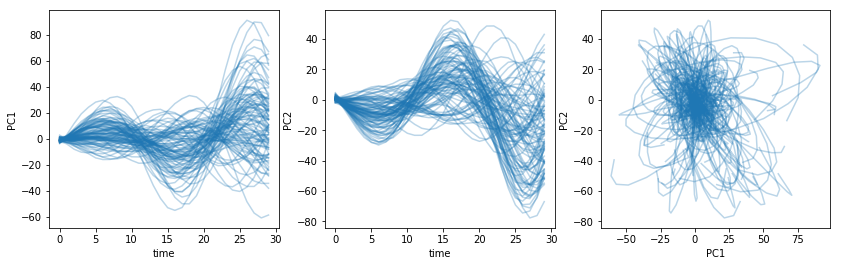

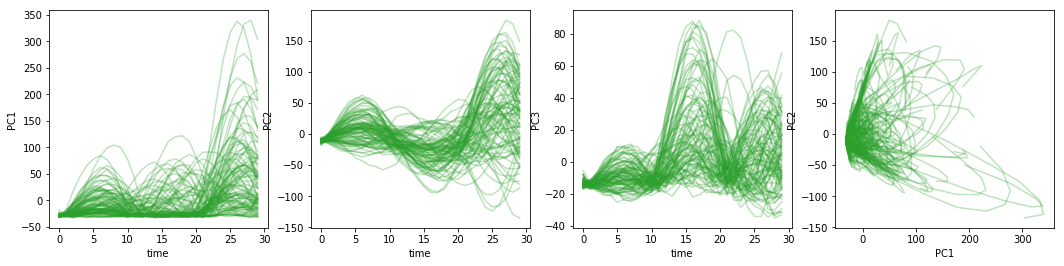

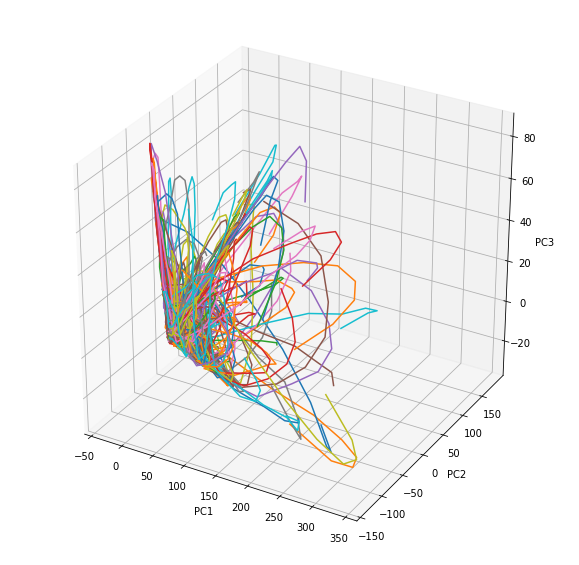

In [86]:
plot_paths(data[0], c="C0", alpha=0.3)
plt.gcf().set_size_inches(14, 4)
plt.savefig("latent_evolutions_case_iii.pdf")


plot_paths(DATA, c="C2", alpha=0.3)
plt.gcf().set_size_inches(18, 4)
plt.savefig("observations_case_iii.pdf")

plot_paths(DATA, c="C0", three_dim=True, alpha=0.3)
plt.gcf().set_size_inches(10, 10)

# Setting Up the Normalizing Flow model

In the case of normalizing flow we are free to choose different generative models.

In the case below we are setting the $p(x, z)$ to be linear transition with MLP emmision with Gaussian noise. `MODEL_LAYERS` indicates the hidden units/layers of the MLP.

For the encoding Normalizing Flow model we choose another MLP to map observations to parameters of the flow.
`RECOGNITION_LAYERS` governs this MLP.

In [173]:
STEPS = 2000

BATCH_SIZE = 1
SAMPLE_SIZE = 10

RECOGNITION_LAYERS = [50, 50]

graph = tf.Graph()

with graph.as_default():
    
    trans_mat_init = []
    for i in range(ORDER):
        trans_mat_init.append(np.eye(LAT_DIM))
    trans_mat_init.append(np.zeros([1, LAT_DIM]))
    trans_mat_init = np.concatenate(trans_mat_init)

    gen_model = FLDS(
            lat_dim=LAT_DIM, obs_dim=DIM, time_steps=TIME,
            init_transition_matrix_bias=trans_mat_init,
            full_covariance=False,
            poisson=False, order=ORDER,
            nonlinear_transform=MLP, hidden_units=[DIM * 2, DIM])

    base_model = StateSpaceNormalDiag(
        np.zeros([TIME, LAT_DIM]), np.ones([TIME, LAT_DIM]))
    recon_model = NormalizingFlowModel(
        in_dim=(TIME, DIM), base_model=base_model,
        norm_flow_type=TimeAutoRegressivePlanarFlow,
        norm_flow_params={"num_layer": 4},
        transform_type=MLP,
        transform_params={"hidden_units": RECOGNITION_LAYERS})

    v = vae(data=TRAIN_DATA, generative_model=gen_model,
            recognition_model=recon_model,
            n_monte_carlo_samples=SAMPLE_SIZE,
            batch_size=BATCH_SIZE,
            optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

    # Losses
    l = v.train(steps=STEPS)
    # Get reconstruction and code for some training samples
    r = v.get_reconstructions(TEST_DATA)
    c = v.get_codes(TEST_DATA)

100%|██████████| 10/10 [00:00<00:00, 13.09it/s]


Text(0.5,0,'Iterations')

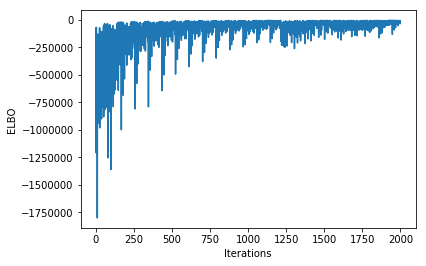

In [174]:
plt.plot(l)
plt.ylabel("ELBO")
plt.xlabel("Iterations")

# Learn, learn, learn...!

In [183]:
with graph.as_default():
    l += v.train(steps=10*STEPS)
    r = v.get_reconstructions(TEST_DATA)
    c = v.get_codes(TEST_DATA)

100%|██████████| 10/10 [00:00<00:00, 330.67it/s]


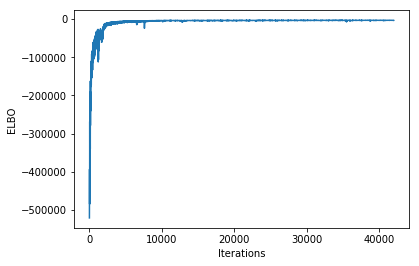

In [184]:
skip = 10
plt.plot(range(len(l))[::skip], np.mean(np.reshape(l, [-1, skip]), axis=-1))
plt.ylabel("ELBO")
plt.xlabel("Iterations")
plt.show()

# FLDS

# Setting Up the fLDS model

parameters that the `FLDSVB` which is an extension of the `AutoEncodinVariationalBayes` is the following:

- `data` with shape (# examples, # time steps, # dimensions)
- `lat_dim`: dimensionality of the latent space
- `n_monte_carlo_samples`: Number of Monte Carlo samples for estimating gradients
- `batch_size`
- `optimizer` which is a tensor flow optimizer
- type of non-linear transformation and it's architecture parameters (In the library there are basic transforms (planning on adding more...)

In [50]:
graph2 = tf.Graph()

recon_idx = range(10)

with graph2.as_default():

    v2 = FLDSVB(data=TRAIN_DATA, lat_dim=LAT_DIM, nonlinear_transform=MLP,
               n_monte_carlo_samples=SAMPLE_SIZE, batch_size=BATCH_SIZE,
               optimizer=tf.train.AdamOptimizer(learning_rate=0.001), full_covariance=False,
               hidden_units=RECOGNITION_LAYERS)
    # Losses
    l2 = v2.train(steps=STEPS)
    # Get reconstruction and code for some training samples
    r2 = v2.get_reconstructions(TEST_DATA)
    c2 = v2.get_codes(TEST_DATA)

100%|██████████| 10/10 [00:00<00:00, 21.59it/s]


Text(0.5,0,'Iterations')

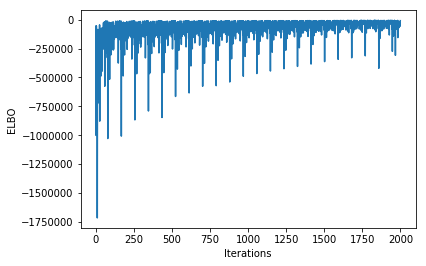

In [51]:
plt.plot(l2)
plt.ylabel("ELBO")
plt.xlabel("Iterations")

In [52]:
with graph2.as_default():
    l2 += v2.train(steps=10*STEPS)
    r2 = v2.get_reconstructions(TEST_DATA)
    c2 = v2.get_codes(TEST_DATA)

100%|██████████| 10/10 [00:00<00:00, 330.52it/s]


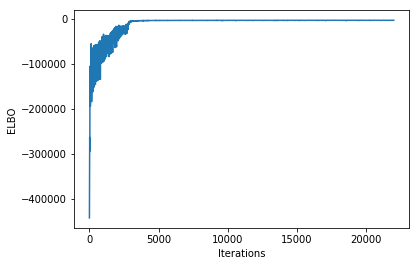

In [53]:
skip = 10
plt.plot(range(len(l))[::skip], np.mean(np.reshape(l2, [-1, skip]), axis=-1))
plt.ylabel("ELBO")
plt.xlabel("Iterations")
plt.show()

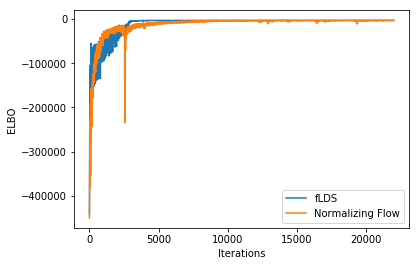

In [61]:
skip = 10
plt.plot(range(len(l))[::skip], np.mean(np.reshape(l2, [-1, skip]), axis=-1))
plt.plot(range(len(l))[::skip], np.mean(np.reshape(l, [-1, skip]), axis=-1))
plt.legend(["fLDS", "Normalizing Flow"])
plt.ylabel("ELBO")
plt.xlabel("Iterations")
plt.savefig("flds_vs_dynamic_norm_flow.pdf")
#plt.ylim(-400, 700)
plt.show()

Text(0.5,1,'Latnet paths from fLDS model')

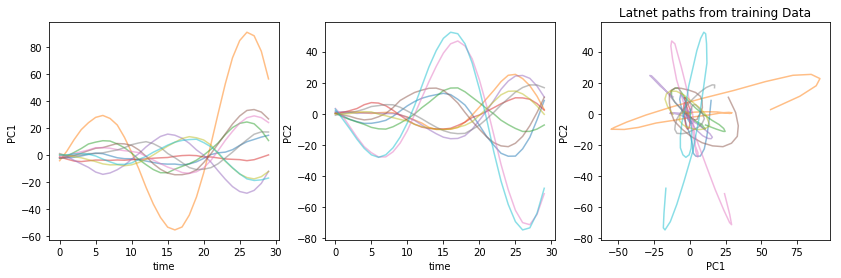

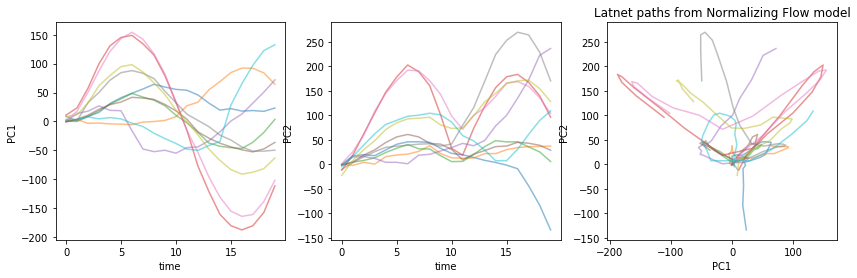

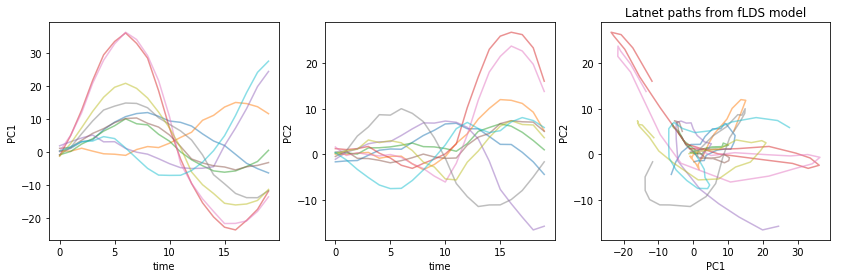

In [185]:
plot_paths(data[0][:10, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Latnet paths from training Data")

plot_paths(np.concatenate(c, axis=0)[::SAMPLE_SIZE, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Latnet paths from Normalizing Flow model")

plot_paths(np.concatenate(c2, axis=0)[::SAMPLE_SIZE, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Latnet paths from fLDS model")

Text(0.5,1,'Reconstructions from fLDS model')

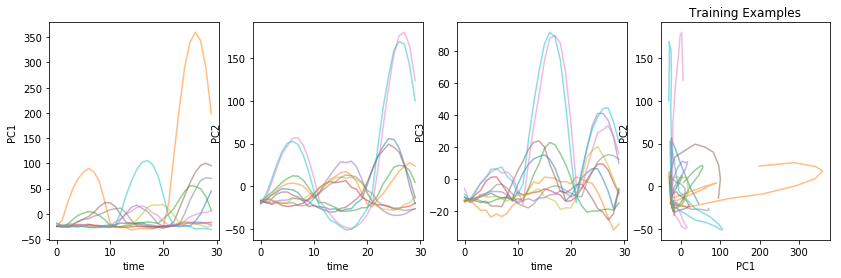

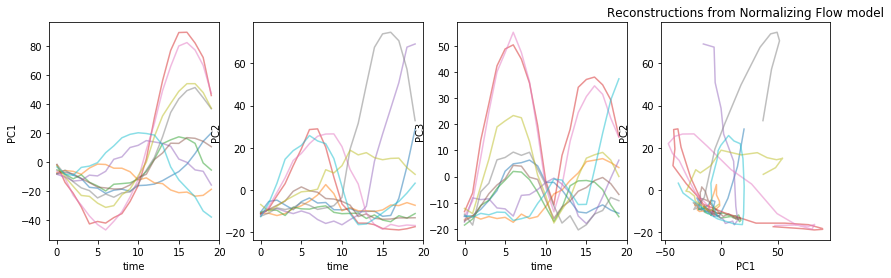

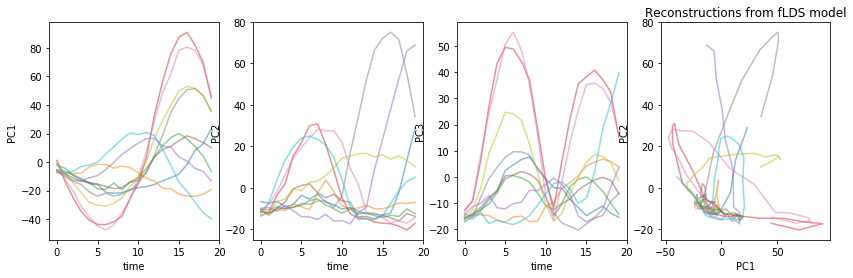

In [186]:
plot_paths(DATA[:10, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Training Examples")

plot_paths(np.concatenate(r, axis=0)[::SAMPLE_SIZE, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Reconstructions from Normalizing Flow model")

plot_paths(np.concatenate(r2, axis=0)[::SAMPLE_SIZE, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Reconstructions from fLDS model")

# Let Evaluate the test set

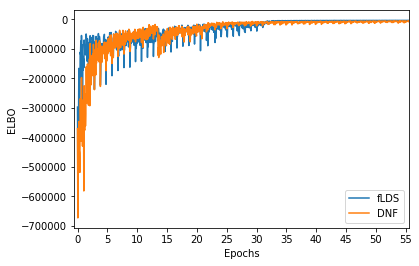

In [189]:
skip = 5
plt.plot(range(len(l2))[::skip], np.mean(np.reshape(l2, [-1, skip]), axis=-1))
plt.plot(range(len(l))[::skip], np.mean(np.reshape(l, [-1, skip]), axis=-1))
plt.legend(["fLDS", "DNF"])
plt.ylabel("ELBO")
plt.xlabel("Epochs")

plt.xticks(90 * np.arange(0, 100, 5), np.arange(0, 100, 5))
plt.xlim(-50, 5000)
plt.savefig("case_iii_elbo.pdf")
plt.show()

In [187]:
N_S = 10

with graph.as_default():
    init_tensor = tf.placeholder(shape=[N_S, ORDER, LAT_DIM], dtype=tf.float64, name="init1")
    extrapolate = v.gen_model.sample(n_samples=N_S, init_states=init_tensor, time_steps=LEAVE_OUT)

with graph2.as_default():
    init_tensor2 = tf.placeholder(shape=[N_S, 1, LAT_DIM], dtype=tf.float64, name="init2")
    extrapolate2 = v2.gen_model.sample(n_samples=N_S, init_states=init_tensor2, time_steps=LEAVE_OUT)

In [192]:
out = []
out2 = []
for i in range(10):
    
    with graph.as_default():
        out.append(v.sess.run(extrapolate, feed_dict={init_tensor.name: c[i, :, -2:, :]}))

    with graph2.as_default():
        out2.append(v2.sess.run(extrapolate2, feed_dict={init_tensor2.name: c2[i, :, -1:, :]}))

In [67]:
TEST_DATA_REST.shape

(10, 10, 10)

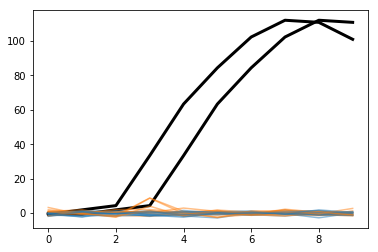

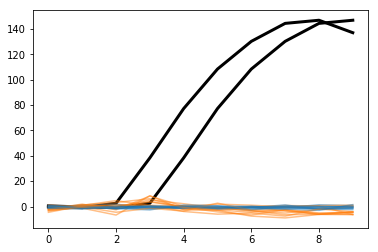

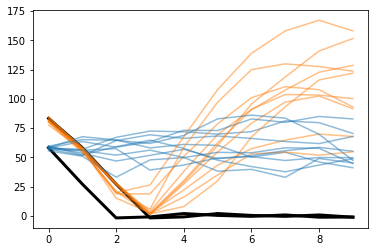

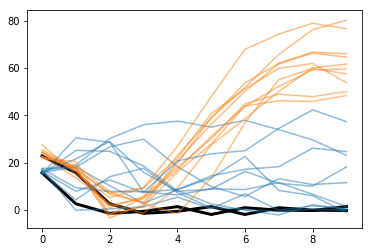

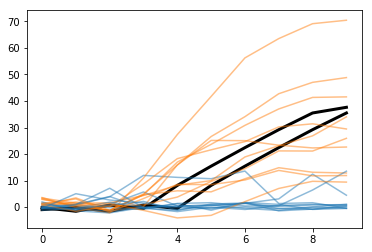

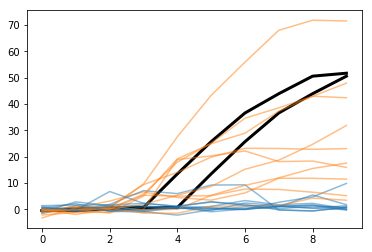

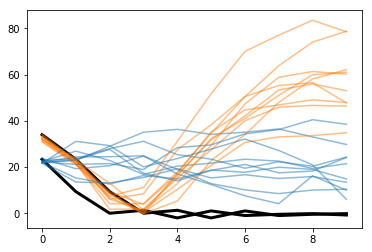

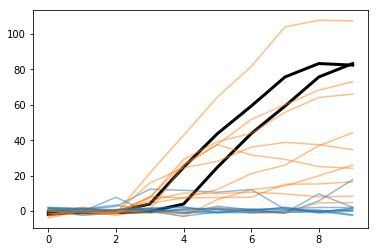

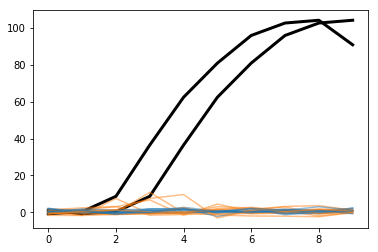

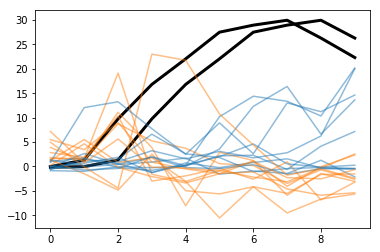

In [120]:
n = 3

for i in range(10):
    plt.plot(TEST_DATA_REST[n, :, i], c='0', lw=3)
    plt.plot(TEST_DATA_REST2[n, :, i], c='0', lw=3)
    for j in range(N_S):
        plt.plot(out[n][1][j, :, i], c='C1', alpha=0.5)
        plt.plot(out2[n][1][j, :, i], c='C0', alpha=0.5)
    plt.show()

In [193]:
nsme = []
nsme2 = []

for n in range(10):
    nsme.append(
        np.square(out[n][1] - TEST_DATA_REST[n:n+1]).sum(-1).mean(0))
    nsme2.append(
        np.square(out2[n][1] - TEST_DATA_REST2[n:n+1]).sum(-1).mean(0))

nsme = np.array(nsme)
nsme2 = np.array(nsme2)

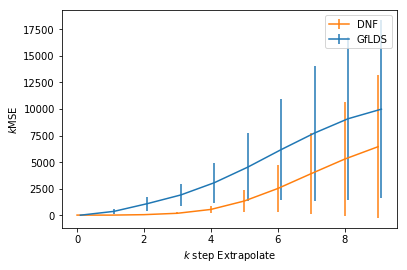

In [194]:
kmse = nsme.cumsum(1) / np.arange(1., 11., 1.)
kmse2 = nsme2.cumsum(1) / np.arange(1., 11., 1.)

plt.errorbar(np.arange(10), kmse.mean(0), kmse.std(0), color='C1')
plt.errorbar(np.arange(10) + .1, kmse2.mean(0), kmse2.std(0), color='C0')

plt.ylabel("$k$MSE")
plt.xlabel("$k$ step Extrapolate")
plt.legend(["DNF", "GfLDS"])
#plt.savefig("case_iii_ksme_1.pdf")

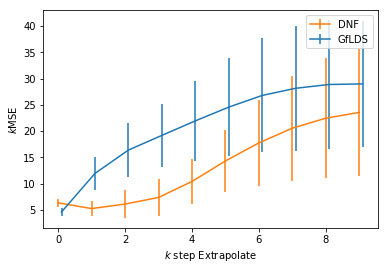

In [80]:
kmse = np.sqrt(nsme.cumsum(1)) / np.arange(1., 11., 1.)
kmse2 = np.sqrt(nsme2.cumsum(1)) / np.arange(1., 11., 1.)

plt.errorbar(np.arange(10), kmse.mean(0), kmse.std(0), color='C1')
plt.errorbar(np.arange(10) + .1, kmse2.mean(0), kmse2.std(0), color='C0')

plt.ylabel("$k$MSE")
plt.xlabel("$k$ step Extrapolate")
plt.legend(["DNF", "GfLDS"])
plt.savefig("case_iii_ksme_2.pdf")

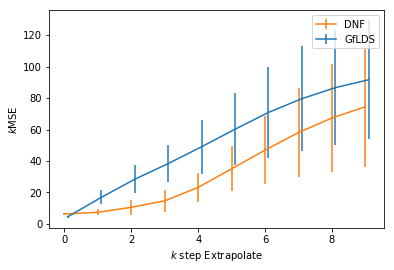

In [82]:
kmse = np.sqrt(nsme.cumsum(1) / np.arange(1., 11., 1.))
kmse2 = np.sqrt(nsme2.cumsum(1) / np.arange(1., 11., 1.))

plt.errorbar(np.arange(10), kmse.mean(0), kmse.std(0), color='C1')
plt.errorbar(np.arange(10) + .1, kmse2.mean(0), kmse2.std(0), color='C0')

plt.ylabel("$k$MSE")
plt.xlabel("$k$ step Extrapolate")
plt.legend(["DNF", "GfLDS"])
plt.savefig("case_iii_ksme_3.pdf")